# This week

- optimal allocation strategies for investors with long-term *liability or consumption objectives*
- suitable for institutional and private investors
- State-of-the-art in **asset-liability management (ALM)**

----

- Define the investor's objectives and constraints
- formalize the risk-return trade-off in terms of final funding ratio
- minimize the opportunity costs of short-term constraints

----

- Conclusion will be:
- Investment decisions should not be framed in terms of one all-encompassing reference policy portfolio
- instead in terms of two distinct reference portfolios
  - a liability-hedging portfolio (LHP)
  - a performance-seeking portfolio (PSP)

# A new paradigm for pension funds: dynamic liability-driven investing (DLDI)

See [EDHEC's publication](https://risk.edhec.edu/publications/dynamic-liability-driven-investing-strategies-emergence-new-investment-paradigm-pension) on it.

# From Asset management to Asset-Liability management

- The presence of liabilities matters for portfolio construction
- There was a Pension Fund Crisis from 1999-2003.
  - "Defined Benefit" (DB) Pension plan assets (those invested in equity) suffered
  - At the same times, liabilities went up because interest rates decreased (the **mark-to-market value** of future liabilities goes up)
    - You can think of the present value of liabilities like a bond portfolio

Conclusion:

- What matters is what happens to the asset value **relative to** liability values.
- Introducing: The **funding ratio**: $F_t = A_t/L_t$
  - If assets go down, but liabilities go down *even more*, then you're happy as an asset-liability manager.
- Alternative measure: The **surplus**: $S_t = A_t - L_t$



# Lab - Present Value of Liabilities and Funding Ratio

----

**The goal of investing is not to grow your assets as large as possible. It is to ensure you have the money you need to to the things you want to do in the future.**

----

The present value of a set of liabilities $L$ where each liability $L_i$ is due at time $t_i$ is given by


$$PV(L) = \sum_{i=1}^k B(t_i)L_i$$

where $B(t)$ is the price of a pure discount bond that pays 1 dollar at time $t_i$. (also der *Abzinsungsfaktor*)

**If we assume the yield curve is flat** and the annual rate of interest is $r$ then $B(t) = \frac{1}{(1+r)^t}$. For example at 3%, then $B(4) \approx 0.97^4$. (because 1/1.03 is not exactly 0.97)

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

In [2]:
def discount(t, r):
    """Compute the price of a pure discount bond that pays $1 at time t given interest rate r"""
    return 1 / ((1+r)**t)

In [3]:
discount(10, 0.03)

0.7440939148967249

In [4]:
def pv(l, r):
    """Compute present value of a set of liabilities.
    l is a pd.Series indexed by the time, the values are the amounts of each liability.
    """
    
    dates = l.index
    discounts = discount(dates, r)  # This function works with pd.Series too
    return (discounts * l).sum()

In [5]:
# 1.5 million USD are due in 3.5 years
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])

In [6]:
pv(liabilities, 0.03)

6.233320315080044

So your liabilities are **"worth" 6.23 million today**, even though the absolute sum is 7 million.

In [7]:
def funding_ratio(assets, liabilities, r):
    """Compute the funding ratio of some assets given liabilities and interest rate"""
    
    return assets / pv(liabilities, r)

In [8]:
# Assume you have 5mm$ today and the same liabilities as before

funding_ratio(5, liabilities, 0.03)

0.8021407126958778

In [9]:
funding_ratio(5, liabilities, 0.09)

1.001034854978827

In [10]:
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print(f'Funding ratio: {fr*100:.2f}%')
    
controls = widgets.interactive(
    show_funding_ratio,
    assets = widgets.IntSlider(min=1, max=10, step=1, value=5),
    r = (0, 0.20, 0.01)
)

display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

So if you find out you're only 80% funded, either your parent company must put in additional money into the pension fund, or you find a way to get a higher return.

# LHPs: Liability hedging portfolios
# Or its exact counterpart: Goal hedging portfolios (GHP) for individual investors

- These are portfolios with payoffs matching the date and nominal amount of either liabilities or goal payments (e.g. your own retirement)
- For that, you can often use derivatives such as interest rate swaps or inflation swaps.

A pension fund investor's **main concern: an unexpected increase in the PV of their liabilities relative to the asset value**

----

- Imagine it's 2018 and our individual investor is retiring in 2035.
- Focus on surviving the first 20 years, until 2055. You want 6€ each year
- A standard bond is shit: You'll get 3€ each year *starting now*, and 100€ repayment in like 2040.

# The Goal hedging portfolio is a retirement bond

- This is a key idea.
- Cash is "safest", and safer than the GHP, if you look at only your asset values.
- But if you look at your **funding ratio, then the GHP is zero-volatility safest**

![ghp1](ghp1.png)

![ghp2](ghp2.png)

![ghp3](ghp3.png)

From an asset-only perspective, cash is safe. But from a long-term liability driven perspective, cash is very risky! (**Because your liabilities move - i.e. the denominator of the funding ratio**)

# There is no unique "safe asset"

It depends on the investor and his goals. Either pure cash, or a GHP can be safer depending on the circumstances.

Clarifying example: The **safe asset** for an investor who has to pay a single inflation-indexed payment 10 years from now is an inflation-linked zero coupon bond with a 10 year duration.

# When cash-flow matching is not feasible/practical you can use factor exposure matching instead

- e.g. hold bonds with the same maturity date as your target payments.
- If you retire in 20y, then hold **deferred inflation-linked annuity with a 20 years deferral period**

----

# Lab - CIR Model and cash vs. Zero-coupon bonds

### Goal: Use the CIR model to see the effect of changes in interest rates. What happens to the price of the Zero Coupon Bond that you're using as a hedge?

The Cox Ingersoll Ross (CIR) model is used to simulate changes in interest rates, it's an extension of the Vasicek model to prevent negative interest rates:

$$dr_t = a(b-r_t)dt + \sigma \sqrt{r_t} dW_t$$

Differential equation, related to Brownian motion. "Small changes to the interest rate $r$ at time $t$ is related to a factor times the difference between the long-term mean interest rate $b$ and the current interest rate $r_t$

The bigger $a$ is, the faster the interest rate will converge back to the mean (if $a=0$, it won't).

----

- If you ignored the $\sqrt{r_t}$ term in the equation, you'd have the Vasicek model. 
- The $\sqrt{r_t}$ is just there to prevent negative interest rates. (ok, but they're not eliminated, they only get *very* unlikely)

### Short Rate (== instantaneous rate, $r_{inst}$) vs. Annualized interest rate

- Short rate: The instantanteous rate you get for a very small amount of time (e.g. a day)

If the interest rate $i$ is applied $N$ times a year (with interest $i/N$), you'll end up with more than if it were applied annually.

You will end up with that much:

$$\left(1 + \frac{r}{N}\right)^N$$

In [11]:
N = 100000
(1 + 0.05 / N)**N

1.051271083242487

And if the interest rate were 100%, compounded "continuously", you'll end up with $e$ Dollars:

In [12]:
(1+1/N)**N

2.7182682371922975

As N becomes large we get the generalizations:

$$1+r_{annual} = e^{r_{inst}}$$

$$r_{annual} = e^{r_{inst}}-1$$

$$r_{inst} = ln(1+r_{annual})$$

**Note:** For realistic interest rates, 2 to 6%, the changes are smaller and not so drastic as with 100% :)

In [13]:
def inst_to_ann(r_inst):
    """Convert a short rate (=instantaneous rate) to an annualized rate"""
    return np.expm1(r_inst)

def ann_to_inst(r_ann):
    """Convert an annualized rate to a short rate"""
    return np.log1p(r_ann)

Let's get back to business:

$$dr_t = a(b-r_t)dt + \sigma \sqrt{r_t} dW_t$$

In [14]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """Implements the CIR model for interest rates"""
    if r_0 is None:
        r_0 = b
    r_0 = ann_to_inst(r_0)  # but why are we transforming them to short rates?
    dt = 1/steps_per_year
    
    num_steps = int(n_years * steps_per_year) + 1  # plus 1 because we hardcode/initialize the first column
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))

    rates = np.empty_like(shock)
    rates[0] = r_0
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a * (b - r_t) * dt + sigma * np.sqrt(r_t) * shock[step]
        rates[step] = abs(r_t + d_r_t)
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

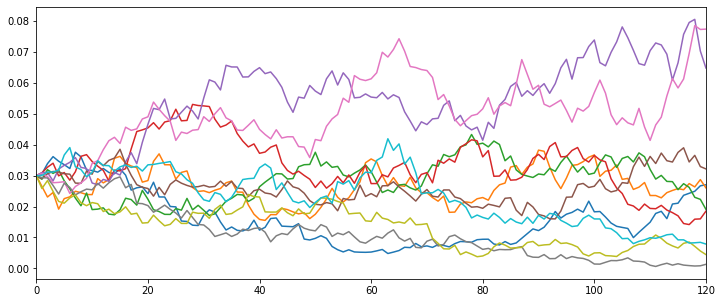

In [15]:
cir(n_scenarios=10).plot(legend=False, figsize=(12, 5))

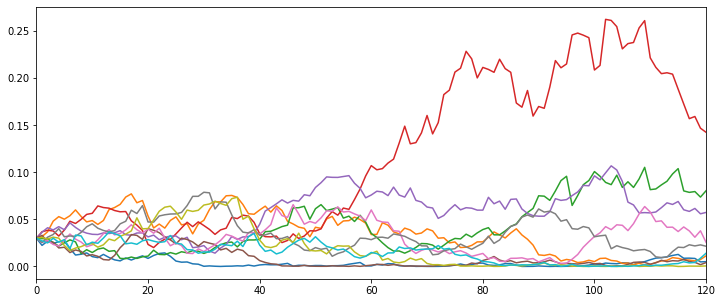

In [16]:
cir(n_scenarios=10, sigma=0.1).plot(legend=False, figsize=(12, 5))

In [17]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5))
   
controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

## Generating the random price evolution of a Zero-Coupon Bond

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations.

The Price $P$ of a bond at time $t$ that matures at $T$ is given by

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$


In [18]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices


In [19]:
# Let's plot the evolution of a zero coupon bond price. At time T of course the price is 1.
# The price before depends on the evolution of interest rates. If they rise, the bond price falls.

def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

Compare this again with the lecture's point that **there is no unique safe asset**. This ZCP *will fluctuate*, but it is 100% safe to be at value 1 at time $T$

In [20]:
# Your assets, "cash-on-hand" at time 0:
a_0 = 0.75

rates, bond_prices = cir(b=0.03, n_scenarios=10)

# Model your liabilities just as these bond prices:
liabilities = bond_prices
# i.e. "The liabilities I want to match is 1 Million USD at the end of 10 years"

**Future liabilities and ZCBs are "the same"**

In [21]:
# The price of a ZCB today:
zc_0 = erk.pv(pd.DataFrame(data=[1], index=[10]), r=0.03)  # present value
zc_0

0    0.744094
dtype: float64

In [22]:
n_bonds = float(a_0) / float(zc_0)  # the number of bonds you can buy

# asset value, assuming you put your money into a ZCB:
av_zc_bonds = n_bonds * bond_prices
# what if you put it in cash instead:
av_cash = a_0 * (rates/12 + 1).cumprod()

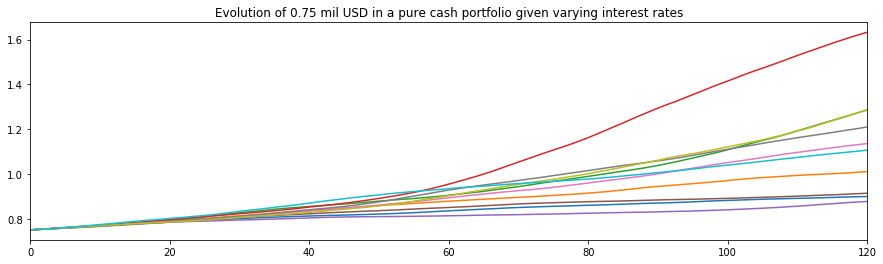

In [23]:
av_cash.plot(legend=False, figsize=(15,4),
             title="Evolution of 0.75 mil USD in a pure cash portfolio given varying interest rates")

# Pure cash is not safe to hedge for a \$1mil liability in 10 years! It won't work every time

-> use ZCBs instead

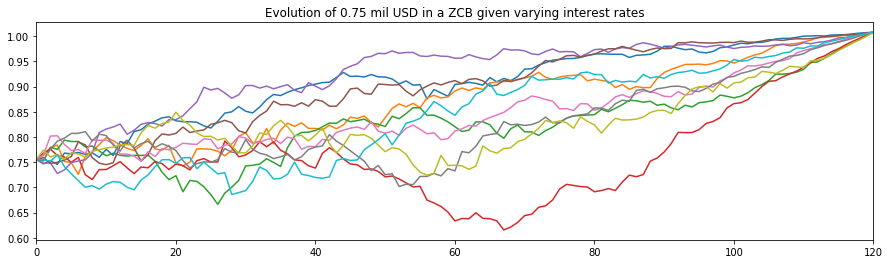

In [24]:
av_zc_bonds.plot(legend=False, figsize=(15,4),
             title="Evolution of 0.75 mil USD in a ZCB given varying interest rates")

# The ZCBs fluctuate more in the beginning, but the terminal value is 1 everywhere

The funding ratio is always 1 because your asset value (ZCBs) is **perfectly correlated** with your liability value (liabilities are modeled as ZCBs)

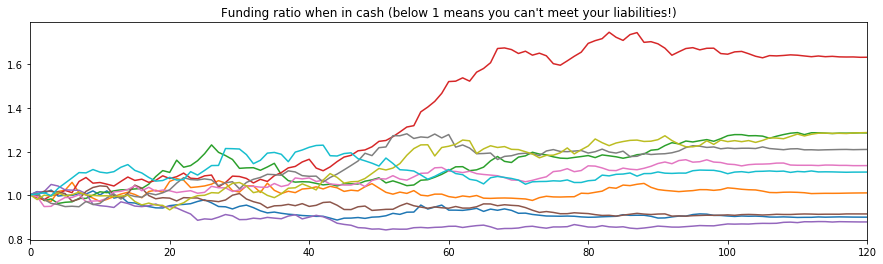

In [25]:
(av_cash/liabilities).plot(legend=False, figsize=(15,4),
                           title="Funding ratio when in cash (below 1 means you can't meet your liabilities!)")

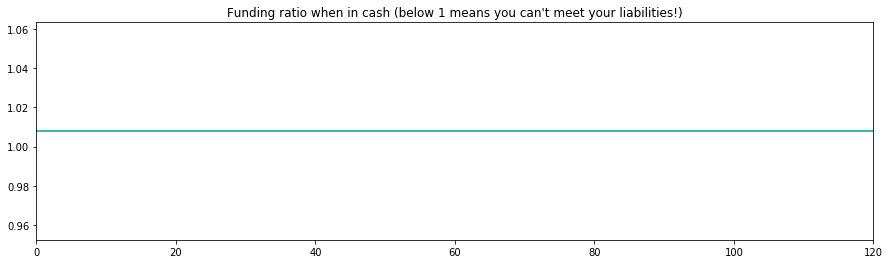

In [26]:
(av_zc_bonds/liabilities).plot(legend=False, figsize=(15,4),
                           title="Funding ratio when in cash (below 1 means you can't meet your liabilities!)")

### Terminal Funding Ratios

We can look at this in terms of Terminal Funding Ratios. Let's repeat this with a large number of simulations:

In [27]:
# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = erk.cir(r_0=0.03, b=0.03, n_scenarios=10000)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = erk.pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest over time
av_cash = a_0*(rates/12+1).cumprod()

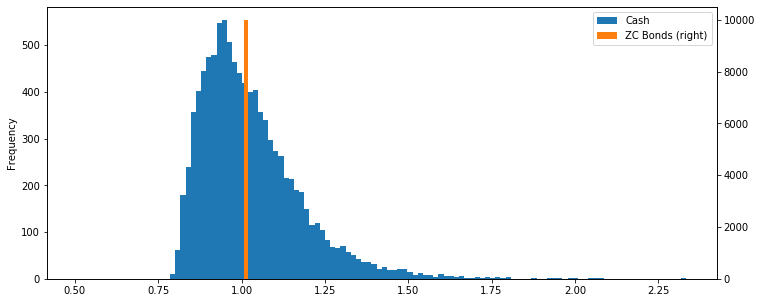

In [28]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(12,5), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax,label="ZC Bonds", bins=100, secondary_y=True, legend=True)

### Conclusion

As you can see, hedging a future liability with cash or even cash-like instruments can be very risky. Although Zero Coupon Bonds are nominally risky and can see a great deal of price fluctuation, they vary in price in tandem with the liabilities, resulting in a much better hedge.

Of course, **this makes two convenient assumptions** that are often not true in practice. First, it assumes that zero coupon bonds with the perfect maturities are always available, and second, it assumes that you have the intial assets to be able to afford the hedge.

We shall try and address these in future sections. We address the first by **holding a portfolio of non zero coupon bonds that will behave like a zero coupon bond** in the sense that it can be liquidated at a particular maturity for an amount that is immunized against changes in interest rates. We'll address the second issue by **introducing a second building block to deliver the higher performance to try and close the gap** between your current assets and the upside target.

# Liability-driven investing (LDI)

- Dominant modern investing paradigm for large institutions' money management

### Dual focus: greed and fear

- You want performance through optimal exposure to rewarded risk factors, *but* you want to hedge against unexpected shocks.
- These two concerns are *best managed separately*.
  - One **performance seeking portfolio** (PSP), maximizing the Sharpe-ratio. This portfolio is **identical** to the risky portfolio in an asset-only context.
  - One **liability hedging portfolio** (LHP), hedging liability risk
  
Formally, the optimal allocation strategy is 

$$\max_w E \left[ u\left( \frac{A_T}{L_T} \right) \right] \Rightarrow w^* = \frac{\lambda_{PSP}}{\gamma \sigma_{PSP}} w^{PSP} + \beta_{L,LHP} \left( 1- \frac{1}{\gamma}\right) w^{LHP} $$

(he didn't explain that equation...)

Maximize a risk-return tradeoff, measured in terms of assets divided by liabilities. Maximize the **expected utility of the funding ratio**.

### Greeks of LDI

- $\lambda_{PSP}$ is the PSP Sharpe Ratio. If $\lambda=0$, there will be *no* investment in PSP
- $\beta_{LHP}$ is the beta of liabilities. If $\beta=0$, you don't want to invest in the LHP
- $\sigma_{PSP}$ is the PSP volatility. $\sigma=\infty \Rightarrow$ no investment in PSP
- $\gamma$ is your risk aversion. $\gamma = \infty \Rightarrow$ no investment in PSP

----

# GHP Construction with Duration matching

As we saw in the previous lab, we can easily match a liability if we had a zero coupon bond that had the exact maturity as the liability, in which case, assuming we had enough funds available, we could do perfect cash flow matching.

In this lab, we'll **use a portfolio of standard, non-coupon bonds to try and achieve the same behaviour as a zero coupon bond.**

In order to do this, we'll have to find a way to price a bond, but as it turns out, we've already written the code to do this. Recall that we implemented the code to compute the present value of a sequence of liability cash flows. Well, a bond is nothing more than a series of cash flows that the issuer is offering to make to you, and therefore, the price of a bond is nothing more than the present value of the future cash flows.

To be more precise, we should use discount rates matching the payment horizons using the yield curve. For simplicity, we'll assume that the yield curve is flat, and the rate of interest is the same regardless of whether it is 1 year, 5 year, 10 year or 30 year horizon. We'll also assume that bonds pay a monthly coupon thereby avoiding some of the complexities of intra-coupon payment. 

In [31]:
erk.bond_cash_flows(
    maturity=3,  # 3 year bond
    principal=100,
    coupon_rate=0.03,
    coupons_per_year=2
)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [36]:
# If discount_rate == coupon_rate, the price == face value

erk.bond_price(
    maturity=3,  # 3 year bond
    principal=100,
    coupon_rate=0.03,
    coupons_per_year=2,
    discount_rate=0.03
)

100.00000000000007

**How is this bond going to change with interest rates?**

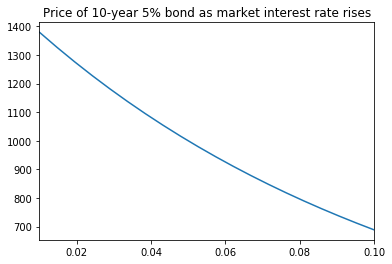

In [43]:
rates = np.linspace(.01, .10, num=20)
prices = [erk.bond_price(10, 1000, .05, 2, rate) for rate in rates]
pd.DataFrame(data=prices, index=rates).plot(
    legend=False, 
    title="Price of 10-year 5% bond as market interest rate rises"
)

**So this bond is a bad hedge for LHPs. The intermediate cashflows you'll get are the problem. You'll need to combine multiple bonds.**

### Central point: OK, now he claims this and I'm out

>  Assume that we have a liability of \\$1000 in 10 years. Clearly, we cannot use this as a hedge, since we would be severely underfunded if interest rates rise, and over funded if they fall.

This doesn't make sense at first sight because you get \\$1000 back anyway at the end of the term.

**BUT** if the coupon is 5% and the current interest rate is 2%, the bond sells for 1.2 times its face value. You buy them for \\$ 1000 but the final payment will be like \\$ 800.

I'm not sure if I understood this.

# Macaulay duration

- The Macaulay duration is the weighted average number of periods you have to be invested in the bond to get the present value of the bond back
- **A ZCB of 10 years has a Macaulay duration of exactly 10 years.**
- But an interest-paying bond of 10 years has a Macaulay duration of e.g. 9.2 years
  - And this leads to the possibility of (*some*, not *severe*) underfunding, I believe.

In [44]:
cf = erk.bond_cash_flows(maturity=3, principal=1000, coupon_rate=0.06, coupons_per_year=2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [47]:
discounts = erk.discount(cf.index, r=0.06/2)
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531596,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [48]:
# discounted cash flows:
dcf = discounts*cf
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [50]:
weights = dcf / dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [52]:
# Now weight each *period* (i.e. the *indices*) by these weights
(cf.index * weights).sum()

5.579707187194534

In [55]:
erk.macaulay_duration(
    erk.bond_cash_flows(maturity=3, principal=1000, coupon_rate=0.06, coupons_per_year=2),
    discount_rate=0.06/2
)

5.579707187194534

This is the **weighted average of all periods**, i.e. the **Macaulay duration**. It's not 6 periods, but 5.57 periods.

**Key insight**: The Macaulay duration is directly linked to the first derivative of price w.r.t. the interest rate. So: If the interest rate changes by something, the change in price depends on the Macaulay duration.

Again: A ZCB of 10 years has a Macaulay duration of exactly 10 years.

# Now:

If you match the Macaulay duration of your bond portfolio to the MacD of your liabilities, you get two portfolios with the same sensitivity to interest rates.

# Duration Matching

- Let's say we have a \\$100k liability in 10 years, and another \\$100k liability in 12 years

In [63]:
liabilities = pd.Series(data=[100000, 100000], index=[10, 12])
erk.macaulay_duration(liabilities, discount_rate=0.04)

10.960799385088393

Now let's assume we only have a 10y bond and a 20y bond available. Both pay 5% and have a face value of \\$1000

We want a bond portfolio with a Macaulay duration of 10.96.

In [69]:
cf_10ybond = erk.bond_cash_flows(maturity=10, principal=1000, coupon_rate=0.05, coupons_per_year=1)

macD_10 = erk.macaulay_duration(
    cf_10ybond,
    discount_rate=0.04
)
macD_10

8.190898824083233

In [70]:
cf_20ybond = erk.bond_cash_flows(maturity=20, principal=1000, coupon_rate=0.05, coupons_per_year=1)

macD_20 = erk.macaulay_duration(
    cf_20ybond,
    discount_rate=0.04
)
macD_20

13.544718122145921

$w_s$ is the weight of the short bond, $w_l = 1-w_s$ is the weight of the long bond.

Now the goal is: $w_s * 8.19 + (1-w_s) * 13.54 = 10.96$

Rearrange to 

$$w_s = \frac{d_l-d_t}{d_l-d_s}$$

$d_t$ is the duration of the target (i.e. 10.96).

In [101]:
# weight of the short bond:
w_s = erk.match_durations(liabilities, cf_10ybond, cf_20ybond, discount_rate=0.04)
w_s

0.48263092069478974

In [102]:
# today's price of the short bond
p_short = erk.bond_price(maturity=10, principal=1000, coupon_rate=0.05, coupons_per_year=1, discount_rate=0.04)
p_long  = erk.bond_price(maturity=20, principal=1000, coupon_rate=0.05, coupons_per_year=1, discount_rate=0.04)
a_0 = 130000  # I have $130'000 available today to pay my future liabilities

# portfolio cashflows:
durationmatched_assets = pd.concat([
    cf_10ybond * (
        a_0 * w_s / p_short),  # this is the number of shares you buy from the short bond
    cf_20ybond * (a_0 * (1-w_s) / p_long)
    
])

In [103]:
durationmatched_assets  # See the duplicated index. It's okay to have it like this. The macauly duration will be computed correctly

1      2901.743586
2      2901.743586
3      2901.743586
4      2901.743586
5      2901.743586
6      2901.743586
7      2901.743586
8      2901.743586
9      2901.743586
10    60936.615315
1      2960.550536
2      2960.550536
3      2960.550536
4      2960.550536
5      2960.550536
6      2960.550536
7      2960.550536
8      2960.550536
9      2960.550536
10     2960.550536
11     2960.550536
12     2960.550536
13     2960.550536
14     2960.550536
15     2960.550536
16     2960.550536
17     2960.550536
18     2960.550536
19     2960.550536
20    62171.561257
dtype: float64

In [104]:
erk.macaulay_duration(durationmatched_assets, discount_rate=0.04)

10.960799385088393

Yay, these flows have the same duration, i.e. 10.96 years, than our liabilities!

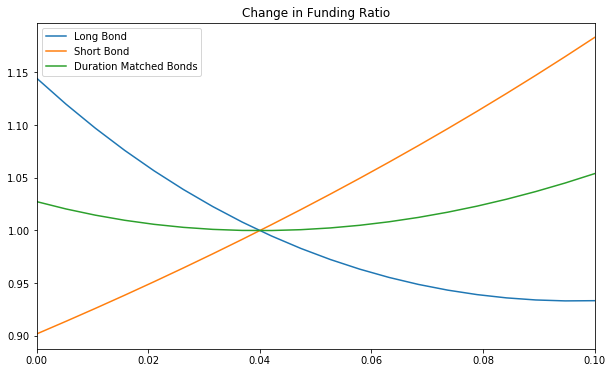

In [105]:
lb_assets = a_0*cf_20ybond/p_long
sb_assets = a_0*cf_10ybond/p_short

rates = np.linspace(0, .1, 20)
fr_change = pd.DataFrame({
    "Long Bond":[erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond":[erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration Matched Bonds":[erk.funding_ratio(durationmatched_assets, liabilities, r) for r in rates]
}, index=rates)
fr_change.plot(title='Change in Funding Ratio', figsize=(10,6))

## What do we see?

- If you had put 100% of your money in the long bond (blue line): if interest rates had gone up, your funding ratio would have gone down :(
- The short bond has a different curve: because it's MacD is shorter than your liability due dates, they (i.e. their funcing ratio) profits from rising interest rates.
- The duration matched portfolio has **almost** no change when interest rates change


## Conclusion

We've seen that if you have the assets on hand, you can secure future liabilities by matching the duration of your liabilities with the durations of your assets to immunize yourself against level shifts in the yield curve. In practice, you might also want to protect against changes in the slope and curvature of the yield curve by using convexity hedging, but duration hedging is a simple but essential step towards ensuring that you will have the money to meet your liabilities when interest rates fluctuate.
